## Train Climate Change Projection Emulator
Recommended to start here. This is a simple demo that uses one emulator for all grid cells.

In [1]:
import sys
import os
home = os.getenv("HOME")
sys.path.insert(0, '../')
sys.path.insert(0, '../setup/')
sys.path.insert(0, '../plotting/')

### IMPORT PACKAGES ####
import GPy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
from sklearn.decomposition import PCA
import multiprocessing as mp

### MY PYTHON FILES ####
from read_file import *
from AreaWeighting import *
from RegionLatitudes import *
from DefineRegions import *
from plotmapfunction import *


In [2]:
# Open datasets
train_input_filename = '../../design/design_matrix_1-86.csv'    # contains 80 perturb runs + 6 control runs
train_output_filename = '../../emulator_files/AllTemps1-86.nc'    

test_input_filename = '../../design/test_matrix_1-18.csv' 
test_output_filename = '../../emulator_files/TestTemps1-18.nc'


X, Y, Xtest, Ytest, latitude, longitude = get_train_test(train_output_filename, train_input_filename,
                                                         test_output_filename, test_input_filename)

Getting inputs and outputs
Opening ../../emulator_files/AllTemps1-86.nc
Getting inputs and outputs
Opening ../../emulator_files/TestTemps1-18.nc


In [3]:
## Check dimensions
nlat, nlon = len(latitude), len(longitude)
print(f"Number of lats: {nlat}. Number of lons: {nlon}. Total grid-cells: {nlat*nlon}")

p = Xtest.shape[1]
print(f"Number of input parameters {p}")

N_train = X.shape[0]
N_test = Xtest.shape[0]

print(f"Training with N_train={N_train}. Testing with N_test={N_test}")

# Check shapes of arrays
print(X.shape, Y.shape)
print(Xtest.shape, Ytest.shape)


Number of lats: 144. Number of lons: 192. Total grid-cells: 27648
Number of input parameters 9
Training with N_train=86. Testing with N_test=18
(86, 9) (86, 144, 192)
(18, 9) (18, 144, 192)


## Preprocess data
We need to 
1. Reshape Y to flatten along longitude latitude, making it 2D rather than 3D.
2. Scale Y to zero mean, unit variance
3. Scale X to zero mean, unit variance

In [4]:
## Reshape arrays: flatten output along lon/lat
Yfull = Y  
Y = Yfull.reshape((Yfull.shape[0], nlon*nlat))
print(Y.shape)


# Scale X and Y to zero mean, unit variance
scalerX = preprocessing.StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
Xtest = scalerX.transform(Xtest)

scalerY = preprocessing.StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)


(86, 27648)


## Gaussian Process
Select a kernel and optimize the Gaussian process. We use a Linear + RBF kernel, but find similar results with different kernel choices. 

In [5]:
## Kernel
kern = GPy.kern.RBF(p,ARD=True) + GPy.kern.Linear(p,ARD=True)

print("kernel used: {}".format(kern))

m = GPy.models.GPRegression(X, Y, kern)
print(f"Model: {m}")

m.optimize()

print(f"Optimised model: {m}")

kernel used:   sum.              |  value  |  constraints  |  priors
  rbf.variance      |    1.0  |      +ve      |        
  rbf.lengthscale   |   (9,)  |      +ve      |        
  linear.variances  |   (9,)  |      +ve      |        
Model: 
Name : GP regression
Objective : 3583917.841185845
Number of Parameters : 20
Number of Optimization Parameters : 20
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |   (9,)  |      +ve      |        
  sum.linear.variances     |   (9,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
Optimised model: 
Name : GP regression
Objective : 1996318.0056321356
Number of Parameters : 20
Number of Optimization Parameters : 20
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  sum.rbf.variance         |  6.671559291057493e-06  |  

## Results
Now we have the Gaussian process, we test it on our test set that we held aside. 

In [6]:
## Test data: Model returns mean and variance
Ypred, var = m.predict(Xtest)
# Un-scale
Ypred = scalerY.inverse_transform(Ypred)
std = np.sqrt((scalerY.var_)*(var))
# Reshape to full lon-lat grid
Ypred = Ypred.reshape(Ypred.shape[0], nlat, nlon)
std = std.reshape(std.shape[0], nlat, nlon)
print(Ypred.shape)

(18, 144, 192)


 /Users/lm2612/miniconda3/envs/GP/lib/python3.7/site-packages/numpy/ma/core.py:3225: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 ../plotting/plotmapfunction.py:47: UserWarning:Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
 /Users/lm2612/miniconda3/envs/GP/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/lm2612/miniconda3/envs/GP/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:385: MatplotlibDeprecationWarning:
The

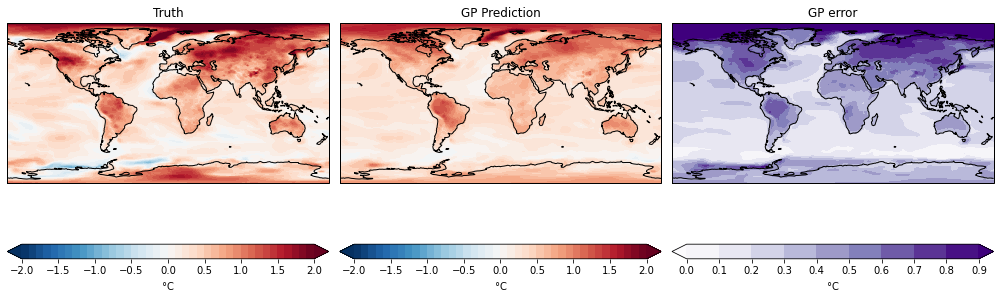

In [7]:
# Let's check some of the results: pick an index between 0 and 18
i = 3

fig = plt.figure(figsize=(14, 6))
ax0 = plt.subplot(131,projection=ccrs.PlateCarree())
ax1 = plt.subplot(132,projection=ccrs.PlateCarree())
ax2 = plt.subplot(133,projection=ccrs.PlateCarree())

levels = np.arange(-2., 2.1, 0.1)
# Plot truth
_, cmap = plotmap(longitude, latitude, Ytest[i], levels = levels,
        variable_label='', plottitle='Truth',
        plotaxis=ax0, colorbar=0, alpha=1)
plt.colorbar(cmap, orientation="horizontal", label="$\degree$C")

# Plot predicted
_, cmap = plotmap(longitude, latitude, Ypred[i], levels = levels,
        variable_label='', plottitle='GP Prediction',
        plotaxis=ax1, colorbar=0, alpha=1)
plt.colorbar(cmap, orientation="horizontal", label="$\degree$C")


# Plot predicted
_, cmap = plotmap(longitude, latitude, std[i], levels = np.arange(0., 1., 0.1),
        variable_label='', plottitle='GP error', cmap="Purples",
        plotaxis=ax2, colorbar=0, alpha=1)
plt.colorbar(cmap, orientation="horizontal", label="$\degree$C")

plt.tight_layout()

We can also take averages over many grid cells. Here, we define some regions and compare the check how well the model predicts for each region. 

In [8]:
# Regional grid
# Take regional means to explore linearity for these 
area = Area(longitude, latitude)
regions = ['Global', 'Europe', 'North_America', 'East_Asia', 'South_Asia', 'Africa', 'South_America', 'Tropics']


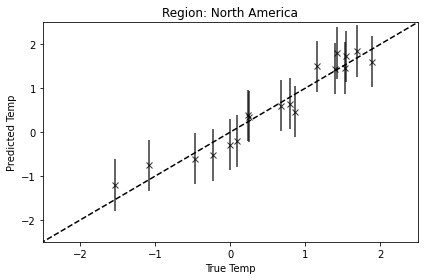

In [9]:
# Select one of the regions above
region = "North_America"

grid = DefineRegion(region, longitude, latitude, regiondict=RegionLonsLats)
for j in range(N_test):
    Ytest_j = np.average(Ytest[j], weights=grid*area)
    Ypred_j = np.average(Ypred[j], weights=grid*area)
    std_j = np.sqrt(np.average(std[j]**2, weights=grid*area))
    plt.errorbar(Ytest_j, Ypred_j, yerr = std_j, fmt='x', color='black', alpha=0.8)

plt.plot([-10.,10.],[-10.,10.],'k--', zorder=100)
plt.xlabel('True Temp')
plt.ylabel('Predicted Temp')
plt.title(f'Region: {region.replace("_"," ")}')
plt.axis(ymin=-2.5, xmin=-2.5, ymax=2.5, xmax=2.5)
plt.tight_layout()

And that's it! Next, try the main code to explore different approaches, including fixing the GP variance using the internal variability or allowing the GP to learn this, creating independent emulators per grid cell or using PCA, or multi-output regression. You can also find more plotting functions in `plots/`. 